In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [2]:
sepsis_df = pd.read_pickle("../data/sepsis_df_median_imputed.pkl")

In [3]:
sepsis_df

,isSepsis,Age,ICULOS,HospAdmTime,Gender,HR,MAP,O2Sat,SBP,Resp,...,Magnesium,Phosphate,Chloride,Temp,HCO3,PTT,AST,Bilirubin_total,Alkalinephos,pH
0,0,83.14,17,-0.03,0,103.0,80.0,90.0,120.0,30.0,...,2.0,3.3,85.0,36.80,45.0,30.7,16.0,0.3,98.0,7.37
1,0,75.91,10,-98.60,0,58.0,77.0,95.0,143.0,11.0,...,2.5,4.4,113.0,36.11,22.0,30.7,32.0,0.8,72.0,7.39
2,0,45.82,11,-1195.71,0,91.0,74.0,94.0,133.0,34.0,...,2.4,2.3,98.0,38.50,31.0,30.5,32.0,0.8,72.0,7.39
3,0,52.01,13,-0.03,1,92.0,80.0,100.0,120.0,18.0,...,2.0,3.4,111.0,36.80,29.0,30.7,32.0,0.8,72.0,7.39
4,0,64.24,2,-0.05,1,155.5,102.0,94.5,147.5,33.0,...,1.9,3.8,113.0,36.80,13.0,26.6,452.0,1.4,88.0,7.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36297,0,76.00,19,-14.90,1,59.0,110.0,95.0,154.0,14.0,...,2.0,3.0,106.0,36.80,24.0,30.7,32.0,0.8,72.0,7.39
36298,0,84.00,25,-6.69,0,81.0,71.0,99.0,122.0,20.0,...,2.3,3.4,106.0,36.80,24.0,30.7,849.0,3.3,259.0,7.39
36299,0,30.00,2,-0.02,1,76.0,79.0,96.0,118.0,14.0,...,2.0,3.4,106.0,36.30,24.0,38.2,24.0,0.7,116.0,7.39
36300,0,60.00,15,-53.64,0,76.0,102.0,89.0,145.0,18.0,...,1.9,4.1,106.0,36.80,24.0,30.7,9.0,0.2,68.0,7.39


In [4]:
X = sepsis_df.drop(columns=['isSepsis'])
y = sepsis_df.isSepsis

In [5]:
# splitting into train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=248)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=248)

In [6]:
# very imbalanced dataset, needs resampling!
from collections import Counter
Counter(y_train)

Counter({0: 21519, 1: 1713})

### Resampling using Random Oversampler, SMOTE, and ADASYN

For the final model scores (Random Forest), SMOTE gave the best results in terms of fbeta (b=2), and scored higher in accuracy and precision, compared to ADASYN, so I have chosen to move forward with SMOTE for my resampling method.

In [7]:
# # resampling using random oversampling
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0)

# X_train, y_train = ros.fit_resample(X_train,y_train)

In [8]:
# resampling using SMOTE
from imblearn.over_sampling import SMOTE

X_train, y_train = SMOTE(random_state=42).fit_resample(X_train,y_train)

In [9]:
# resampling using ADASYN
# from imblearn.over_sampling import ADASYN

# X_train, y_train = ADASYN(random_state=42).fit_resample(X_train,y_train)

In [10]:
Counter(y_train)

Counter({0: 21519, 1: 21519})

In [11]:
# import standard scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [12]:
from sklearn.metrics import make_scorer
# creating a new scoring metric that uses beta = 2
f_beta_2 = make_scorer(fbeta_score, beta=2)

In [13]:
def scores(y_true, y_pred, model):
    
    model_score_df = pd.DataFrame()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fbeta = fbeta_score(y_true, y_pred, beta=2) 
    
    temp_df = pd.DataFrame([[str(model), accuracy, precision, recall, f1, fbeta]])
        
    model_score_df = pd.concat([model_score_df, temp_df])
    model_score_df.columns = ['model', 'accuracy', 'precision', 'recall', 'f1', 'fbeta']
    
    return model_score_df

In [14]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val_scaled)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

## KNN

In [15]:
knn = KNeighborsClassifier(n_neighbors = 5, weights='distance')
knn.fit(X_train_scaled, y_train)

knn_train_pred = knn.predict(X_train_scaled)
knn_val_pred = knn.predict(X_val_scaled)

In [16]:
scores(y_train, knn_train_pred, 'knn')

,model,accuracy,precision,recall,f1,fbeta
0,knn,1.0,1.0,1.0,1.0,1.0


In [17]:
scores(y_val, knn_val_pred, 'knn')

,model,accuracy,precision,recall,f1,fbeta
0,knn,0.659666,0.152203,0.826087,0.257046,0.438125


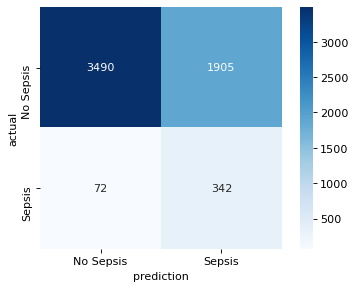

In [18]:
make_confusion_matrix(knn)

## Logistic Regression

In [19]:
logit = LogisticRegression()
logit.fit(X_train_scaled, y_train)

logit_train_pred = logit.predict(X_train_scaled)
logit_val_pred = logit.predict(X_val_scaled)

In [20]:
scores(y_train, logit_train_pred, 'logit')

,model,accuracy,precision,recall,f1,fbeta
0,logit,0.773967,0.808197,0.718435,0.760677,0.734756


In [21]:
scores(y_val, logit_val_pred, 'logit')

,model,accuracy,precision,recall,f1,fbeta
0,logit,0.531761,0.113606,0.818841,0.199529,0.365302


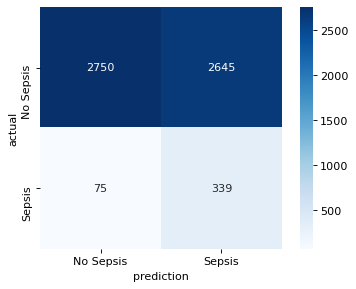

In [22]:
make_confusion_matrix(logit)

## Random Forest

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_train_pred = rf.predict(X_train)
rf_val_pred = rf.predict(X_val)

In [24]:
scores(y_train, rf_train_pred, 'rf')

,model,accuracy,precision,recall,f1,fbeta
0,rf,1.0,1.0,1.0,1.0,1.0


In [25]:
scores(y_val, rf_val_pred, 'rf')

,model,accuracy,precision,recall,f1,fbeta
0,rf,0.968669,0.792929,0.758454,0.775309,0.765107


In [26]:
def make_confusion_matrix_unscaled(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    sepsis_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(sepsis_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No Sepsis', 'Sepsis'],
           yticklabels=['No Sepsis', 'Sepsis']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

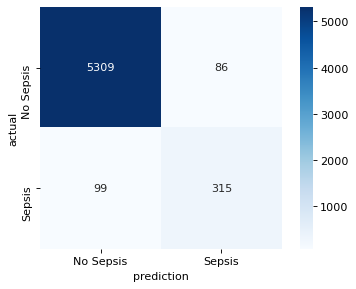

In [27]:
make_confusion_matrix_unscaled(rf)

## ROC AUC Curve

In [28]:
knn_fpr, knn_tpr, knn_thresh = roc_curve(y_val, knn.predict_proba(X_val_scaled)[:,1])
logit_fpr, logit_tpr, logit_thresh = roc_curve(y_val, logit.predict_proba(X_val_scaled)[:,1])
rf_fpr, rf_tpr, rf_thresh = roc_curve(y_val, rf.predict_proba(X_val)[:,1])

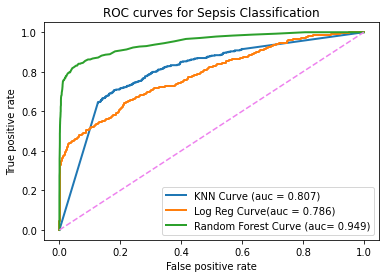

In [29]:
# fpr, tpr, thresholds = roc_curve(y_val, rf.predict_proba(X_val)[:,1])

roc_auc_knn = (roc_auc_score(y_val, knn.predict_proba(X_val_scaled)[:,1]))
roc_auc_logit = (roc_auc_score(y_val, logit.predict_proba(X_val_scaled)[:,1]))
roc_auc_rf = (roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))                    
plt.plot(knn_fpr, knn_tpr, lw=2, label = f'KNN Curve (auc = {roc_auc_knn.round(3)})')
plt.plot(logit_fpr, logit_tpr, lw=2, label = f'Log Reg Curve(auc = {roc_auc_logit.round(3)})')
plt.plot(rf_fpr, rf_tpr, lw=2, label = f'Random Forest Curve (auc= {roc_auc_rf.round(3)})')





plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curves for Sepsis Classification');
# print("ROC AUC score = ", roc_auc_score(y_val, rf.predict_proba(X_val)[:,1]))
plt.legend(loc='lower right')

In [30]:
fbeta_knn = fbeta_score(y_val, knn_val_pred, beta=2)
fbeta_logit = fbeta_score(y_val, logit_val_pred, beta=2)
fbeta_rf = fbeta_score(y_val, rf_val_pred, beta=2)

In [31]:
f_beta_scores = {'model':['knn','logistic regression','random forest'],
                 'score':[fbeta_score(y_val, knn_val_pred, beta=2),
                          fbeta_score(y_val, logit_val_pred, beta=2),
                         fbeta_score(y_val, rf_val_pred, beta=2)]}

In [32]:
f_beta_scores

{'model': ['knn', 'logistic regression', 'random forest'],
 'score': [0.43812451960030746, 0.36530172413793105, 0.7651072124756335]}

In [33]:
fbeta_df = pd.DataFrame.from_dict(f_beta_scores)

In [34]:
fbeta_df

,model,score
0,knn,0.438125
1,logistic regression,0.365302
2,random forest,0.765107


Text(0.5, 1.0, 'Baseline F-beta (b=2) Scores')

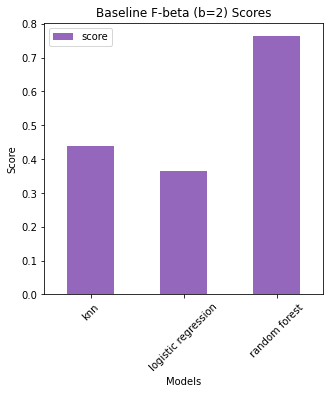

In [35]:
fbeta_df.plot(x = 'model', kind='bar', color='tab:purple', figsize=(5,5))
plt.xticks(rotation=45)
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Baseline F-beta (b=2) Scores')

In [36]:
feature_importance_df = pd.DataFrame({'feat_importance':rf.feature_importances_}, index=X_val.columns).sort_values(by='feat_importance', ascending=False)

In [37]:
knn_scores = scores(y_val, knn_val_pred, 'knn')
logit_scores = scores(y_val, logit_val_pred, 'logistic regression')
rf_scores = scores(y_val, rf_val_pred, 'random forest')

In [38]:
all_scores_df = knn_scores.append(logit_scores).append(rf_scores)

In [39]:
all_scores_df

,model,accuracy,precision,recall,f1,fbeta
0,knn,0.659666,0.152203,0.826087,0.257046,0.438125
0,logistic regression,0.531761,0.113606,0.818841,0.199529,0.365302
0,random forest,0.968669,0.792929,0.758454,0.775309,0.765107


In [40]:
def score_visualizer(df):
    ax = df.plot(x='model', kind='bar', figsize=(9,5))
    
    plt.xticks(rotation=45)
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Baseline Scores for All Models')
    plt.legend(['accuracy','precision', 'recall', 'f1', 'fbeta'],shadow = True, loc = 2, bbox_to_anchor=(1.0, 0.5));

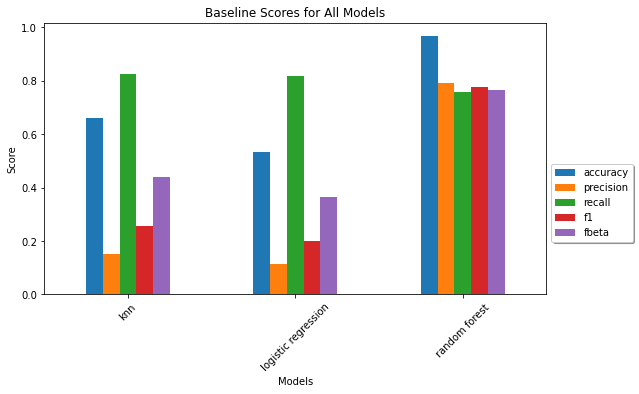

In [41]:
score_visualizer(all_scores_df)